##### Copyright 2024 Google LLC.

In [ ]:
# @title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Workshop: How to Fine-tuning Gemma

To illustrate fine-tuning the model for a specific task, You'll learn how to condition a Gemma model to answer in a specific language. Let's consider the example of generating a random Portuguese title based on a user's instruction such as "Write a title". To make this possible, you will curate a manageable dataset that can be manually processed. This approach is feasible because Gemma 2 has prior knowledge of general Portuguese language patterns, enabling it to adapt to this specific task effectively.

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/google-gemini/gemma-cookbook/blob/main/Workshops/Workshop_How_to_Fine_tuning_Gemma.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

## What is Fine-tuning

In the first place, you have to understand what is fine-tuning. It's a specialized form of [transfer learning](https://en.wikipedia.org/wiki/Transfer_learning). It involves taking a pre-trained language model - one that has already been exposed to a vast corpus of text data and learned the general patterns and structures of language - and further training it on a smaller, more specific dataset. This additional training allows the model to adapt and refine its knowledge, making it better suited for a particular task or domain.

Imagine you are a skilled gamer who excels at various genres, from action-adventures to strategy games. Fine-tuning is akin to taking you and having you focus intensely on mastering a specific game, like a complex real-time strategy (RTS) title. You already possess a strong foundation of gaming skills and knowledge, but the dedicated practice and study within the RTS genre sharpens your tactics, understanding of game mechanics, and overall proficiency within that particular realm.

Similarly, pre-trained language models have a broad understanding of language, but fine-tuning helps them specialize. By exposing them to a curated dataset relevant to your desired application, you guide the model to learn the nuances and intricacies specific to that domain. It's like giving the model a crash course in the language of your chosen field, enabling it to perform tasks with greater accuracy and fluency.


## Setup

### Select the Colab runtime
To complete this tutorial, you'll need to have a Colab runtime with sufficient resources to run the Gemma model:

1. In the upper-right of the Colab window, select **▾ (Additional connection options)**.
2. Select **Change runtime type**.
3. Under **Hardware accelerator**, select **T4 GPU**.


### Gemma setup on Kaggle
To complete this tutorial, you'll first need to complete the setup instructions at [Gemma setup](https://ai.google.dev/gemma/docs/setup). The Gemma setup instructions show you how to do the following:

* Get access to Gemma on kaggle.com.
* Select a Colab runtime with sufficient resources to run the Gemma 2B model.
* Generate and configure a Kaggle username and API key.

After you've completed the Gemma setup, move on to the next section, where you'll set environment variables for your Colab environment.

### Set environemnt variables

Set environment variables for ```KAGGLE_USERNAME``` and ```KAGGLE_KEY```.

In [ ]:
import os
from google.colab import userdata, drive

# Note: `userdata.get` is a Colab API. If you're not using Colab, set the env
# vars as appropriate for your system.
os.environ["KAGGLE_USERNAME"] = userdata.get("KAGGLE_USERNAME")
os.environ["KAGGLE_KEY"] = userdata.get("KAGGLE_KEY")

# Mounting gDrive for to store artifacts
drive.mount("/content/drive")

### Install dependencies

Install Keras and KerasNLP

In [ ]:
!pip install -q -U keras-nlp datasets
!pip install -q -U keras

# Set the backbend before importing Keras
os.environ["KERAS_BACKEND"] = "jax"
# Avoid memory fragmentation on JAX backend.
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "1.00"

import keras_nlp
import keras

# Run at half precision.
#keras.config.set_floatx("bfloat16")

# Training Configurations
token_limit = 128
num_data_limit = 100
lora_name = "my_lora"
lora_rank = 4
lr_value = 1e-3
train_epoch = 5
model_id = "gemma2_instruct_2b_en"

## Load Model

**Why Fine-tuning?**

Before embarking on fine-tuning, it's crucial to evaluate if its benefits align with the specific requirements of your application. Fine-tuning involves meticulous data preparation and extensive training, making it an arduous process. Therefore, it's essential to assess whether the potential gains justify the significant effort required.

**Try "Prompt Engineering" first.** before fine-tuning

Would you like to enable Gemma's multilingual capabilities?
Please note that Gemma 2 already has some multilingual capabilities. Here's the example output from Gemma 2 2B instruction-tuned model.

Do you wish to adjust the tone or writing style?
Gemma 2 might be familiar with the writing style you have in mind. Here's another output from the same model.

In [ ]:
import keras
import keras_nlp

import time

gemma_lm = keras_nlp.models.GemmaCausalLM.from_preset(model_id)
gemma_lm.summary()

tick_start = 0

def tick():
    global tick_start
    tick_start = time.time()

def tock():
    print(f"TOTAL TIME ELAPSED: {time.time() - tick_start:.2f}s")

def text_gen(prompt):
    tick()
    input = f"<start_of_turn>user\n{prompt}<end_of_turn>\n<start_of_turn>model\n"
    output = gemma_lm.generate(input, max_length=token_limit)
    print("\nGemma output:")
    print(output)
    tock()


In [ ]:
# inference before fine-tuning
text_gen("Translate the text below to Portuguese.\n\"Hi, how can I get to the MASP museum?\"")
text_gen("Speak like a pirate. Teach me why the earth is flat.")
text_gen("Write a title")
text_gen("Write a poem")

## What is a Tokenizer

A tokenizer is a crucial component that bridges the gap between human language and the numerical representations that AI models can understand. It's essentially a tool that breaks down text into smaller units, called tokens, which can then be processed by the model.

Think of it like this:

- Humans: Communicate using words, sentences, and paragraphs.
- LLMs: They "think" in terms of numbers and vectors.

The tokenizer acts as a translator between these two worlds. It takes human-readable text and converts it into a format that the LLM can understand and work with.



Gemma tokenizer is based on [SentencePiece](https://github.com/google/sentencepiece). The size of the vocabulary is predetermined before training. SentencePiece then learns the optimal subword segmentation based on the chosen vocabulary size and the training data.

Gemma's large 256k vocabulary allows it to handle diverse text inputs and potentially improve performance on various tasks, e.g. handling multilingual text inputs.

Gemma's tokenizer uses byte-level encoding, which means it can handle any character from any language, even those with different writing systems (like Chinese, Japanese, or Korean).

This avoids the limitations of character-based tokenizers, which might struggle with languages that have a vast number of characters.

In [ ]:
tokenizer = keras_nlp.models.GemmaTokenizer.from_preset(model_id)
import jax

def detoken(tokens):
  print(tokens)
  for x in tokens:
    word = tokenizer.detokenize(jax.numpy.array([x]))
    print(f"{x:6} -> {word}")

# (example text: “Hi, Nice to meet you. The weather is really nice today.”)
detoken(tokenizer("olá. Prazer em conhecê-lo. O tempo está muito bom hoje."))
print()
detoken(tokenizer("नमस्ते। आपसे मिलकर अच्छा लगा। आज मौसम सचमुच अच्छा है."))

## Load Dataset

How many datasets do you need? You can start with a relatively small dataset, approximately 10 to 20, those can have a significant impact on a model's behavior.

To improve the output quality, a target of around 200 total examples is recommended. Nevertheless, the amount of data required for tuning really depends on how much you want to influence the model's behavior. Our recommendation is to commence with a limited amount of data and gradually incorporate additional data into the training process until the desired behavior is achieved.

In [ ]:
tokenizer = keras_nlp.models.GemmaTokenizer.from_preset(model_id)

# example titles
data = [
    "O Alquimista",  # by Paulo Coelho
    "Dom Casmurro",  # by Machado de Assis
    "Memorial do Convento",  # by José Saramago
    "A Hora da Estrela",  # by Clarice Lispector
    "Vidas Secas",  # by Graciliano Ramos
    "O Cortiço",  # by Aluísio Azevedo
    "Grande Sertão: Veredas",  # by Guimarães Rosa
    "Capitães da Areia",  # by Jorge Amado
    "A Sibila",  # by Agustina Bessa-Luís
    "Os Maias",  # by Eça de Queirós
    "O Crime do Padre Amaro",  # by Eça de Queirós
    "A Relíquia",  # by Eça de Queirós
    "O Primo Basílio",  # by Eça de Queirós
    "A Ilustre Casa de Ramires",  # by Eça de Queirós
    "A Cidade e as Serras"  # by Eça de Queirós
]

train = []

for x in data:
  item = f"<start_of_turn>user\nWrite a title<end_of_turn>\n<start_of_turn>model\n{x}<end_of_turn>"
  length = len(tokenizer(item))
  # skip data if the token length is longer than our limit
  if length < token_limit:
    train.append(item)
    if(len(train)>=num_data_limit):
      break

print(len(train))
print(train[0])
print()
print(train[1])
print()
print(train[2])

See below example code, using HF datasets, if your datasets are much bigger.

In [ ]:
# Example of using HF datasets
# Replying to request emails that a bakery business might get, in Korean
# The given prompt means "Please write an email reply with below."
'''
tokenizer = keras_nlp.models.GemmaTokenizer.from_preset(model_id)

# prompt structure
# <start_of_turn>user
# 다음에 대한 이메일 답장을 작성해줘.
# "{EMAIL CONTENT FROM THE CUSTOMER}"
# <end_of_turn>
# <start_of_turn>model
# {MODEL ANSWER}<end_of_turn>

# input, output
from datasets import load_dataset
ds = load_dataset(
    "bebechien/korean_cake_boss",
    split="train",
)
print(ds)
data = ds.with_format("np", columns=["input", "output"], output_all_columns=False)
train = []

for x in data:
  item = f"<start_of_turn>user\n다음에 대한 이메일 답장을 작성해줘.\n\"{x['input']}\"<end_of_turn>\n<start_of_turn>model\n{x['output']}<end_of_turn>"
  length = len(tokenizer(item))
  # skip data if the token length is longer than our limit
  if length < token_limit:
    train.append(item)
    if(len(train)>=num_data_limit):
      break

print(len(train))
print(train[0])
print(train[1])
print(train[2])
'''

In the context of a small dataset, the primary concern is that the model may prioritize memorizing specific examples rather than generalizing well to new and unobserved data. This limitation highlights the importance of utilizing a larger dataset during fine-tuning, as it enhances the model's ability to capture broader patterns and relationships.

## LoRA Fine-tuning

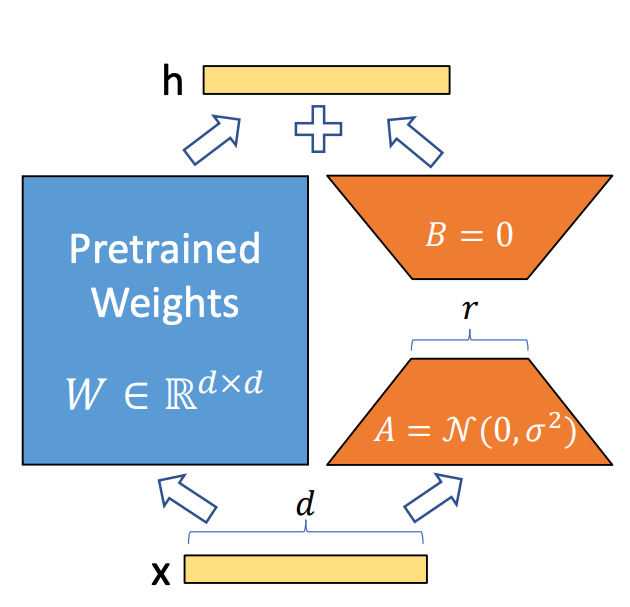

Fine-tuning a model involves updating its weights (also called parameters). LLMs have a lot of weights. The Gemma 2 2B that is being used in this notebook has 2,617,270,528 parameters!

Changing all of them can take quite some time and requires a lot of resources.

To mitigate this issue, you are going to use a technique called: [LoRA: Low-Rank Adaptation](https://arxiv.org/abs/2106.09685)

This technique, in summary, helps lower the number of trained weights needed by a lot, making fine-tuning more accessible.

The key parameter used is the `rank`. In this notebook it set to 4 but you can use higher numbers to get better results but, of course, needed more resources.

**TIP**: Train your model with lower ranks and evaluate the performance improvemnet on your task. Gradually increase the rank in subsequent trials and see if that further boosts performance.

In [ ]:
# Enable LoRA for the model and set the LoRA rank to 4.
gemma_lm.backbone.enable_lora(rank=lora_rank)
gemma_lm.summary()

# Limit the input sequence length (to control memory usage).
gemma_lm.preprocessor.sequence_length = token_limit
# Use AdamW (a common optimizer for transformer models).
optimizer = keras.optimizers.AdamW(
    learning_rate=lr_value,
    weight_decay=0.01,
)
# Exclude layernorm and bias terms from decay.
optimizer.exclude_from_weight_decay(var_names=["bias", "scale"])

gemma_lm.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=optimizer,
    weighted_metrics=[keras.metrics.SparseCategoricalAccuracy()],
)


Note that enabling LoRA reduces the number of trainable parameters significantly.

From 2,617,270,528 to **2,928,640**

To monitor the learning progress, you will evaluate the model at the end of each epoch and save the lora weights.

In [ ]:
!ls

In [ ]:
# !cd drive
!mkdir -p ./drive/MyDrive/gemma_workshop
# !cd ..

In [ ]:
class CustomCallback(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    model_name = f"./drive/MyDrive/gemma_workshop/{lora_name}_{lora_rank}_epoch{epoch+1}.lora.h5"
    gemma_lm.backbone.save_lora_weights(model_name)

    # Evaluate
    text_gen("Write a title")
    text_gen("Write a poem")

history = gemma_lm.fit(train, epochs=train_epoch, batch_size=2, callbacks=[CustomCallback()])

import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.show()

Note that the model began to grasp our intent more effectively from Epoch #3 onwards.

To compare and contrast, it was utlized the "Write a poem" prompt. Interestingly, in Epoch #5, the model began to generate Portuguese in response to that prompt. This shift indicates a strong influence of our training dataset on the model's behavior. However, depending on your application, such a significat change might not be desirable. In such cases, Epoch #4 would be a more suitable choice.

## Load LoRA

Use the code below if you shared LoRA weights. It's much more lightweight than the model files themselves - for instance, a LoRA rank 4 weights file for a 10gb model might only be on the order of a few megabytes, easily shared over email.

In [ ]:
# Example Code for Load LoRA
'''
gemma_lm = keras_nlp.models.GemmaCausalLM.from_preset(model_id)
# Use the same LoRA rank that you trained
gemma_lm.backbone.enable_lora(rank=4)
train_epoch = 3
# Load pre-trained LoRA weights
gemma_lm.backbone.load_lora_weights(f"/content/drive/MyDrive/{lora_name}_{lora_rank}_epoch{train_epoch}.lora.h5")
'''

## Try a different sampler

The top-K algorithm randomly picks the next token from the tokens of top K probability.

In [ ]:
gemma_lm.compile(sampler="top_k")
text_gen("Write a title")
text_gen("Write a title")
text_gen("Write a title")
text_gen("Write a title")
text_gen("Write a title")

Try a slight different prompts

In [ ]:
text_gen("Write a music title")
text_gen("Write a poem title")
text_gen("Write a blog title")
text_gen("Write a movie title")
text_gen("Write a novel title")

## Publish your model

Lets save our model. It takes some time (~11 minutes) as it is a very large file

In [ ]:
# Save the finetuned model
my_model_name = "my_gemma2_pt"
gemma_lm.save_to_preset(f"./{my_model_name}")

## Publishing on Hugging Face

To publish your model on Hugging Face, you'll need to add your hugging face user (`HF_USER`) and an access token with write permission (`HF_TOKEN`) to the your secret keys.

In [ ]:
my_hf_username = userdata.get("HF_USER")
os.environ["HF_USER"] = my_hf_username
os.environ["HF_TOKEN"] = userdata.get("HF_TOKEN")

In [ ]:
# Upload the model to Hugging Face Hub
my_model_name = "my_gemma2_pt"
hf_uri = f"hf://{my_hf_username}/{my_model_name}"
keras_nlp.upload_preset(hf_uri, f"./{my_model_name}")

## Publishing on Kaggle

To publish on Kaggle you will need you username (already using if you followed the suggested setup process) and a name for your model and run the following cell

**Note**: After the following cell, the model will be private to you on Kaggle. To share more broadly, change it to public.

In [ ]:
# Upload the model to Kaggle
my_user_name = os.environ["KAGGLE_USERNAME"]
my_model_name = "my_gemma2_pt"
kaggle_uri = f"kaggle://{my_user_name}/gemma/keras/{my_model_name}"
keras_nlp.upload_preset(kaggle_uri, f"./{my_model_name}")